In [1]:
import akshare as ak
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['font.sans-serif'] = ['AR PL UKai CN','Noto Sans Kaithi']
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

           date      黄金      短融      长债       股票
0    2020-12-21  1.4721  1.0177  1.0000  1.20895
1    2020-12-25  1.4578  1.0184  0.9998  1.18210
2    2020-12-30  1.4513  1.0196  1.0006  1.17315
3    2020-12-31  1.4504  1.0203  1.0007  1.18035
4    2021-01-04  1.4795  1.0204  1.0007  1.17780
...         ...     ...     ...     ...      ...
1185 2025-11-14  3.4280  1.1770  1.2121  2.00450
1186 2025-11-17  3.3661  1.1773  1.2139  1.99175
1187 2025-11-18  3.3152  1.1775  1.2137  1.97455
1188 2025-11-19  3.3796  1.1774  1.2116  1.97850
1189 2025-11-20  3.3618  1.1774  1.2108  1.98265

[1190 rows x 5 columns]


<Axes: >

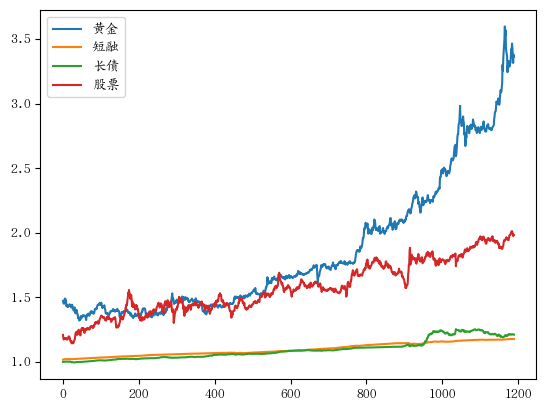

In [3]:
def merge_fund_data_by_date(*dataframes):
    merged_df = dataframes[0][['date', 'price']].copy()
    merged_df.columns = ['date', 'price_0']
    for i, df in enumerate(dataframes[1:], 1):
        temp_df = df[['date', 'price']].copy()
        temp_df.columns = ['date', f'price_{i}']
        merged_df = merged_df.merge(temp_df, on='date', how='inner')
    price_columns = [col for col in merged_df.columns if col.startswith('price_')]
    merged_df['price'] = merged_df[price_columns].sum(axis=1)/len(price_columns)
    return merged_df[['date', 'price']]

def quit_zero(stock):
    stock_zero_mask = stock['price'] == 0
    zero_indices = stock[stock_zero_mask].index
    for idx in zero_indices:
        # 查找前一个非零值
        prev_idx = idx - 1
        while prev_idx >= 0 and stock.loc[prev_idx, 'price'] == 0:
            prev_idx -= 1
        
        # 查找后一个非零值
        next_idx = idx + 1
        while next_idx < len(stock) and stock.loc[next_idx, 'price'] == 0:
            next_idx += 1
        
        # 计算前后非零值的平均值
        prev_value = stock.loc[prev_idx, 'price'] if prev_idx >= 0 else 0
        next_value = stock.loc[next_idx, 'price'] if next_idx < len(stock) else prev_value
        
        # 如果前值为0但后值不为0，则使用后值
        if prev_value == 0 and next_value != 0:
            stock.loc[idx, 'price'] = next_value
        # 如果后值为0但前值不为0，则使用前值
        elif next_value == 0 and prev_value != 0:
            stock.loc[idx, 'price'] = prev_value
        # 如果前后值都不为0，则取平均值
        elif prev_value != 0 and next_value != 0:
            stock.loc[idx, 'price'] = (prev_value + next_value) / 2
        # 如果都为0，则保持原值（这种情况很少见）

# 黄金 000218
# 短融 000128, 008448
# 长债  003376
# 30长债 010309
# 美债 004998
# 红利 161907, 510880, 009051
# 红利低波 005561, 512890, 021482
# 标普 161125
# 纳斯达克 160213
# 创业板 110026
# 上证50 001051
# 沪深300 460300
def get_data():
    d1 = ak.fund_open_fund_info_em(symbol="000218", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
    cash = ak.fund_open_fund_info_em(symbol="008448", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'}) #短融现金储备不能改
    d2 = ak.fund_open_fund_info_em(symbol="010309", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
    #股票
    d3 = ak.fund_open_fund_info_em(symbol="009051", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
    d4 = ak.fund_open_fund_info_em(symbol="512890", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
    stock = merge_fund_data_by_date(d3, d4)
    # d3 = ak.fund_open_fund_info_em(symbol="110026", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
    # d4 = ak.fund_open_fund_info_em(symbol="001051", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
    # d5 = ak.fund_open_fund_info_em(symbol="460300", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
    # stock = merge_fund_data_by_date(d3, d4, d5)
    # d6 = ak.fund_open_fund_info_em(symbol="512890", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
    # stock = merge_fund_data_by_date(d3, d4, d5, d6)
    quit_zero(stock)
    dataframes = [d1, cash, d2, stock]
    merged_data = reduce(lambda left, right: left.merge(right, on='date', how='inner', suffixes=('', '_right')), dataframes)
    merged_data.columns = ['date', '黄金', '短融', '长债', '股票']
    merged_data['date'] = pd.to_datetime(merged_data['date'])
    return merged_data

# def get_data():
#     d1 = ak.fund_open_fund_info_em(symbol="000218", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
#     cash = ak.fund_open_fund_info_em(symbol="000128", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'}) #短融现金储备不能改
#     d2 = ak.fund_open_fund_info_em(symbol="003376", indicator="累计净值走势").rename(columns={'净值日期': 'date', '累计净值': 'price'})
#     d7 = pd.read_csv('./btc_daily_nav_2016_to_now.csv')
#     d7['date'] = pd.to_datetime(d7['date']).dt.date
#     d1['date'] = pd.to_datetime(d1['date']).dt.date
#     cash['date'] = pd.to_datetime(cash['date']).dt.date
#     d2['date'] = pd.to_datetime(d2['date']).dt.date
#     dataframes = [d1, cash, d2, d7]
#     merged_data = reduce(lambda left, right: left.merge(right, on='date', how='inner', suffixes=('', '_right')), dataframes)
#     merged_data.columns = ['date', '黄金', '短融', '长债', '股票']
#     # 如果需要，可以将日期列转换回datetime类型
#     merged_data['date'] = pd.to_datetime(merged_data['date'])
#     return merged_data
merged_data = get_data()
start_year = 2018
start_month = 4
first_date = merged_data['date'].iloc[0]
if first_date.month == 12:
    start_year = first_date.year + 1
    start_month = 1
else:
    start_year = first_date.year
    start_month = first_date.month + 1
end_year = datetime.now().year
end_month = datetime.now().month
print(merged_data)
merged_data[['黄金', '短融', '长债', '股票']].plot()

In [ ]:
def equal_risk(current_price, see_months=3, invest_amount=10000):
    merged_data = get_data()
    recent_data = merged_data.tail(see_months*20).copy()
    etf_columns = ['黄金', '长债', '股票']
    for col in etf_columns:
        recent_data.loc[:, f'{col}_pct'] = recent_data.loc[:, col].pct_change(fill_method=None) * 100

    pct_columns = ['黄金_pct', '长债_pct', '股票_pct']
    etf_data = recent_data.loc[:, pct_columns]
    daily_returns = etf_data.dropna()
    volatility = daily_returns.std() * np.sqrt(252)
    print(f"各类资产{see_months}个月年化波动率：")
    print(volatility.round(4), "\n")
    current_weights = current_price / current_price.sum()
    current_weights = pd.Series(current_weights, index=pct_columns)

    # 风险贡献 = 仓位权重 × 资产波动率
    risk_contribution = current_weights * volatility
    total_risk = risk_contribution.sum()

    # 风险贡献占比（当前风险比例）
    risk_ratio = (risk_contribution / total_risk).round(4) * 100
    print("当前仓位的风险贡献占比：")
    print(risk_ratio, "\n")

    target_risk_ratio = 1/3  # 33.33%

    # 加仓系数 = 目标风险占比 / 当前风险占比（风险越高，系数越小，加仓越少）
    add_coefficient = target_risk_ratio / (risk_ratio / 100)
    print("定投加仓系数：")
    print(add_coefficient.round(4), "\n")

    # 分配加仓金额（假设当月定投1万元）
    add_weights = add_coefficient / add_coefficient.sum()  # 加仓比例
    add_amount = (add_weights * invest_amount).round(0)

    print(f"{invest_amount}元定投的加仓金额分配：")
    result = pd.DataFrame({
        '当前仓位权重': current_weights * 100,
        '当前风险占比(%)': risk_ratio,
        '加仓系数': add_coefficient.round(4),
        '定投金额(元)': add_amount
    })
    print(result)

equal_risk(np.array([1, 1, 1]), 12, 158000)

In [ ]:
def analyze_etf_monthly_data(year, month):
    """
    分析指定年月的ETF数据并计算风险比例和相关系数
    
    Parameters:
    year (int): 年份
    month (int): 月份
    
    Returns:
    tuple: (risk_contribution, correlation_matrix)
    """
    merged_data = get_data()
    
    mask = (merged_data['date'].dt.year == year) & (merged_data['date'].dt.month == month)
    monthly_data = merged_data.loc[mask].copy() 
    
    if monthly_data.empty:
        print(f"警告: {year}年{month}月没有找到数据")
        return None, None
    
    etf_columns = ['黄金', '短融', '长债', '股票']
    for col in etf_columns:
        monthly_data.loc[:, f'{col}_pct'] = monthly_data.loc[:, col].pct_change(fill_method=None) * 100
    
    pct_columns = ['黄金_pct', '短融_pct', '长债_pct', '股票_pct']
    etf_data = monthly_data.loc[:, pct_columns]
    etf_data = etf_data.dropna()
    
    if etf_data.empty:
        print(f"警告: {year}年{month}月数据不足，无法计算统计指标")
        return None, None
    
    volatility = etf_data.std() * np.sqrt(252)  # 年化波动率
    total_volatility = volatility.sum()
    risk_contribution = volatility / total_volatility * 100
    
    return risk_contribution, etf_data.corr()

def get_etf_analysis_period(start_year, start_month, end_year, end_month):
    """
    获取指定时间段内每月的ETF风险比例和相关系数矩阵
    
    Parameters:
    start_year (int): 开始年份
    start_month (int): 开始月份
    end_year (int): 结束年份
    end_month (int): 结束月份
    
    Returns:
    dict: 包含每月风险比例和相关系数矩阵的字典
    """
    results = {}
    current_year = start_year
    current_month = start_month
    
    while (current_year < end_year) or (current_year == end_year and current_month <= end_month):
        try:
            risk_ratio, corr_matrix = analyze_etf_monthly_data(current_year, current_month)
            if risk_ratio is not None and corr_matrix is not None:
                results[f"{current_year}-{current_month:02d}"] = {
                    'risk_ratio': risk_ratio,
                    'corr_matrix': corr_matrix
                }
            else:
                print(f"{current_year}年{current_month:02d}月 数据不足或不存在")
        except Exception as e:
            print(f"处理 {current_year}年{current_month:02d}月 数据时出错: {e}")
        current_month += 1
        if current_month > 12:
            current_month = 1
            current_year += 1
    return results

In [ ]:
def print_summary_statistics(results):
    """
    打印汇总统计信息
    """
    if not results:
        print("没有数据可供统计")
        return
    
    dates = sorted(list(results.keys()))
    etf_names = list(results[list(results.keys())[0]]['risk_ratio'].index)
    
    periods = {
        "近1个月": 1,
        "近3个月": 3,
        "近半年": 6,
        "近1年": 12,
        "近3年": 36,
        "从最早到目前为止": len(dates)
    }
    
    for period_name, months in periods.items():
        if months >= len(dates):
            period_dates = dates 
        else:
            start_index = max(0, len(dates) - months)
            period_dates = dates[start_index:]
        
        if not period_dates:
            print(f"\n{period_name}: 没有数据")
            continue
            
        avg_risk_data = {}
        for etf in etf_names:
            avg_risk_data[etf] = sum([results[date]['risk_ratio'][etf] for date in period_dates]) / len(period_dates)
        
        print(f"\n{period_name} ({period_dates[0]} 到 {period_dates[-1]}):")
        print("  平均风险比例:")
        for etf, ratio in avg_risk_data.items():
            print(f"    {etf}: {ratio:.4f}")
        
        if months <= 6:
            continue
        median_risk_data = {}
        for etf in etf_names:
            risk_values = [results[date]['risk_ratio'][etf] for date in period_dates]
            risk_values.sort()
            n = len(risk_values)
            if n % 2 == 0:
                median_risk_data[etf] = (risk_values[n//2 - 1] + risk_values[n//2]) / 2
            else:
                median_risk_data[etf] = risk_values[n//2]
        
        print("  中位数风险比例:")
        for etf, ratio in median_risk_data.items():
            print(f"    {etf}: {ratio:.4f}")
        
def visualize_risk_ratios(results):
    """
    可视化风险比例变化趋势
    """
    if not results:
        print("没有数据可供可视化")
        return
    
    # 准备数据
    dates = list(results.keys())
    etf_names = list(results[list(results.keys())[0]]['risk_ratio'].index)
    
    # 创建DataFrame存储风险比例数据
    risk_data = {}
    for etf in etf_names:
        risk_data[etf] = [results[date]['risk_ratio'][etf] for date in dates]
    
    risk_df = pd.DataFrame(risk_data, index=dates)
    
    # 绘制风险比例变化图
    plt.figure(figsize=(24, 8))
    for etf in etf_names:
        plt.plot(risk_df.index, risk_df[etf], marker='o', label=etf, linewidth=2)
    
    plt.title('各ETF风险比例月度变化趋势', fontsize=16)
    plt.xlabel('月份', fontsize=12)
    plt.ylabel('风险比例', fontsize=12)
    plt.legend()
    plt.xticks(rotation=65)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
def calculate_portfolio_drawdown_and_recovery(merged_data, weights):
    """
    计算给定权重的投资组合的最大回撤和回撤修复时间
    
    Parameters:
    merged_data (DataFrame): 包含各资产净值数据的DataFrame
    weights (dict): 各资产的权重配置
    
    Returns:
    tuple: (最大回撤, 回撤开始日期, 回撤结束日期, 修复日期, 修复月数)
    """
    # 计算组合净值
    portfolio_value = pd.Series(0, index=merged_data.index)
    
    # 归一化初始价格，使所有资产起始值为1
    for asset in weights.keys():
        normalized_prices = merged_data[asset] / merged_data[asset].iloc[0]
        portfolio_value += normalized_prices * weights[asset]
    
    # 创建组合数据DataFrame
    portfolio_df = pd.DataFrame({
        'date': merged_data['date'],
        'value': portfolio_value
    })
    
    # 按日期排序
    portfolio_df = portfolio_df.sort_values('date').reset_index(drop=True)
    
    # 计算累积净值序列的峰值
    portfolio_df['peak'] = portfolio_df['value'].expanding(min_periods=1).max()
    
    # 计算回撤
    portfolio_df['drawdown'] = (portfolio_df['value'] - portfolio_df['peak']) / portfolio_df['peak']
    
    # 找到最大回撤的位置
    max_drawdown_idx = portfolio_df['drawdown'].idxmin()
    max_drawdown = portfolio_df.loc[max_drawdown_idx, 'drawdown']
    
    # 获取最大回撤的日期信息
    max_drawdown_date = portfolio_df.loc[max_drawdown_idx, 'date']
    
    # 找到回撤开始前的峰值日期
    peak_value = portfolio_df.loc[max_drawdown_idx, 'peak']
    # peak_idx = portfolio_df[portfolio_df['date'] <= max_drawdown_date][portfolio_df['value'] == peak_value].index[-1]
    mask = (portfolio_df['date'] <= max_drawdown_date) & (portfolio_df['value'] == peak_value)
    peak_idx = portfolio_df[mask].index[-1]
    peak_date = portfolio_df.loc[peak_idx, 'date']
    
    # 计算修复时间
    recovery_idx = None
    recovery_date = None
    recovery_months = None
    
    # 寻找回撤修复日期（净值重新达到峰值）
    for idx in range(max_drawdown_idx + 1, len(portfolio_df)):
        if portfolio_df.loc[idx, 'value'] >= peak_value:
            recovery_idx = idx
            recovery_date = portfolio_df.loc[idx, 'date']
            # 计算月份数
            months = (recovery_date.year - peak_date.year) * 12 + (recovery_date.month - peak_date.month)
            recovery_months = months
            break
    
    return max_drawdown, peak_date, max_drawdown_date, recovery_date, recovery_months

def calculate_max_drawdown_and_recovery(data, asset_column):
    """
    计算最大回撤和回撤修复时间
    
    Parameters:
    data (DataFrame): 包含日期和资产净值的数据
    asset_column (str): 资产列名
    
    Returns:
    tuple: (最大回撤, 回撤开始日期, 回撤结束日期, 修复日期, 修复月数)
    """
    # 确保数据按日期排序
    df = data[['date', asset_column]].copy()
    df = df.sort_values('date').reset_index(drop=True)
    
    # 计算累积净值序列的峰值
    df['peak'] = df[asset_column].expanding(min_periods=1).max()
    
    # 计算回撤
    df['drawdown'] = (df[asset_column] - df['peak']) / df['peak']
    
    # 找到最大回撤的位置
    max_drawdown_idx = df['drawdown'].idxmin()
    max_drawdown = df.loc[max_drawdown_idx, 'drawdown']
    
    # 获取最大回撤的日期信息
    max_drawdown_date = df.loc[max_drawdown_idx, 'date']
    
    # 找到回撤开始前的峰值日期
    peak_value = df.loc[max_drawdown_idx, 'peak']
    mask = (df['date'] <= max_drawdown_date) & (df[asset_column] == peak_value)
    peak_idx = df[mask].index[-1]
    peak_date = df.loc[peak_idx, 'date']
    
    # 计算修复时间
    recovery_idx = None
    recovery_date = None
    recovery_months = None
    
    # 寻找回撤修复日期（净值重新达到峰值）
    for idx in range(max_drawdown_idx + 1, len(df)):
        if df.loc[idx, asset_column] >= peak_value:
            recovery_idx = idx
            recovery_date = df.loc[idx, 'date']
            # 计算月份数
            months = (recovery_date.year - peak_date.year) * 12 + (recovery_date.month - peak_date.month)
            recovery_months = months
            break
    
    return max_drawdown, peak_date, max_drawdown_date, recovery_date, recovery_months


# 绘制组合回撤曲线图
def plot_portfolio_drawdown(merged_data, weights):
    """
    绘制投资组合的回撤曲线
    """
    # 计算组合净值
    portfolio_value = pd.Series(0, index=merged_data.index)
    
    # 归一化初始价格，使所有资产起始值为1
    for asset in weights.keys():
        normalized_prices = merged_data[asset] / merged_data[asset].iloc[0]
        portfolio_value += normalized_prices * weights[asset]
    
    # 创建组合数据DataFrame
    portfolio_df = pd.DataFrame({
        'date': merged_data['date'],
        'value': portfolio_value
    })
    
    # 按日期排序
    portfolio_df = portfolio_df.sort_values('date').reset_index(drop=True)
    
    # 计算累积净值序列的峰值和回撤
    portfolio_df['peak'] = portfolio_df['value'].expanding(min_periods=1).max()
    portfolio_df['drawdown'] = (portfolio_df['value'] - portfolio_df['peak']) / portfolio_df['peak']
    
    # 绘制图形
    plt.figure(figsize=(14, 10))
    
    # 子图1: 组合净值走势
    plt.subplot(2, 1, 1)
    plt.plot(portfolio_df['date'], portfolio_df['value'], color='purple', linewidth=2, label='组合净值')
    plt.plot(portfolio_df['date'], portfolio_df['peak'], color='green', linestyle='--', linewidth=1, label='历史峰值')
    plt.title('投资组合净值走势', fontsize=14)
    plt.ylabel('净值')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 标注最大回撤点
    max_dd_idx = portfolio_df['drawdown'].idxmin()
    max_dd_value = portfolio_df.loc[max_dd_idx, 'drawdown']
    max_dd_date = portfolio_df.loc[max_dd_idx, 'date']
    max_dd_nav = portfolio_df.loc[max_dd_idx, 'value']
    peak_value = portfolio_df.loc[max_dd_idx, 'peak']
    
    plt.scatter(max_dd_date, max_dd_nav, color='red', s=80, zorder=5)
    plt.annotate(f'最大回撤点\n{max_dd_value*100:.2f}%', 
                xy=(max_dd_date, max_dd_nav), 
                xytext=(20, 20), 
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # 子图2: 回撤曲线
    plt.subplot(2, 1, 2)
    plt.plot(portfolio_df['date'], portfolio_df['drawdown'], color='red', linewidth=2)
    plt.fill_between(portfolio_df['date'], portfolio_df['drawdown'], 0, color='red', alpha=0.3)
    plt.title('投资组合回撤曲线', fontsize=14)
    plt.ylabel('回撤 (%)')
    plt.xlabel('日期')
    plt.grid(True, alpha=0.3)
    
    # 标注最大回撤点
    plt.scatter(max_dd_date, max_dd_value, color='darkred', s=80, zorder=5)
    plt.annotate(f'最大回撤\n{max_dd_value*100:.2f}%', 
                xy=(max_dd_date, max_dd_value), 
                xytext=(20, -20), 
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    plt.tight_layout()
    plt.show()
    
    return portfolio_df


In [ ]:
print(f"开始分析{start_year}年{start_month}月至{end_year}年{end_month}月的ETF数据...")
results = get_etf_analysis_period(start_year, start_month, end_year, end_month)
print_summary_statistics(results)
visualize_risk_ratios(results)
# 定义资产权重
portfolio_weights = {
    '短融': 0.25,
    '长债': 0.25,
    '黄金': 0.25,
    '股票': 0.25,
}

# 计算组合最大回撤和修复时间
try:
    max_dd, peak_date, dd_date, recovery_date, recovery_months = calculate_portfolio_drawdown_and_recovery(
        merged_data, portfolio_weights
    )
    
    print("="*60)
    print("指定权重组合的最大回撤及修复时间分析")
    print("="*60)
    print("组合权重配置:")
    for asset, weight in portfolio_weights.items():
        print(f"  {asset}: {weight*100:.1f}%")
    print()
    print("分析结果:")
    print(f"  最大回撤: {max_dd*100:.2f}%")
    print(f"  回撤开始日期(峰值): {peak_date.strftime('%Y-%m-%d')}")
    print(f"  最大回撤日期: {dd_date.strftime('%Y-%m-%d')}")
    
    if recovery_date:
        print(f"  回撤修复日期: {recovery_date.strftime('%Y-%m-%d')}")
        print(f"  修复时间: {recovery_months} 个月")
    else:
        print("  回撤修复日期: 尚未修复")
        # 计算至今的修复时间
        last_date = merged_data['date'].max()
        months_since_peak = (last_date.year - peak_date.year) * 12 + (last_date.month - peak_date.month)
        print(f"  至今修复时间: {months_since_peak} 个月 (尚未完全修复)")

except Exception as e:
    print(f"计算组合回撤时出现错误: {e}")
# 绘制组合回撤曲线
portfolio_df = plot_portfolio_drawdown(merged_data, portfolio_weights)

# 与各单项资产回撤对比
print("\n" + "="*60)
print("组合与各单项资产最大回撤对比")
print("="*60)

# 计算并显示各单项资产的回撤
individual_drawdowns = {}
assets = ['黄金', '短融', '长债', '股票']

print(f"{'资产':<10} {'最大回撤':<10} {'修复时间':<10}")
print("-" * 30)
for asset in assets:
    max_dd, _, _, _, recovery_months = calculate_max_drawdown_and_recovery(merged_data, asset)
    individual_drawdowns[asset] = abs(max_dd)
    recovery_text = f"{recovery_months}个月" if recovery_months else "未修复"
    print(f"{asset:<10} {max_dd*100:>9.2f}% {recovery_text:<10}")

# 计算组合回撤
max_dd, peak_date, dd_date, recovery_date, recovery_months = calculate_portfolio_drawdown_and_recovery(merged_data, portfolio_weights)
portfolio_max_dd = max_dd
print(f"{'组合':<10} {portfolio_max_dd*100:>9.2f}% {recovery_months if recovery_months else '未修复':<10}")

# 计算风险降低效果
avg_individual_drawdown = np.mean(list(individual_drawdowns.values()))
risk_reduction = (avg_individual_drawdown - abs(portfolio_max_dd)) / avg_individual_drawdown * 100

print(f"\n风险分散效果:")
print(f"  各资产平均最大回撤: {avg_individual_drawdown*100:.2f}%")
print(f"  组合最大回撤: {abs(portfolio_max_dd)*100:.2f}%")
print(f"  风险降低幅度: {risk_reduction:.2f}%")

# 简单回测

# 原始方法

In [ ]:
import pandas as pd

def backtest_new_method(start_year, start_month, price_per_month, M, initial_capital=100000):
    """
    每月先补短融到25%，剩余资金投入其余3个资产中仓位最低的资产。
    每月额外打印：每个资产相对成本的收益率。
    """

    df = get_data().copy()
    df['date'] = pd.to_datetime(df['date'])

    start_ts = pd.Timestamp(start_year, start_month, 1)
    df = df[df['date'] >= start_ts].sort_values("date").reset_index(drop=True)

    # 月末价格
    df_m = df.set_index("date").resample("M").last().reset_index()
    assets = ['黄金', '短融', '长债', '股票']

    if len(df_m) < M + 1:
        raise ValueError(f"数据不足，需要至少 {M+1} 个月。")

    # ===============================
    # 初始建仓
    # ===============================
    cost = {a: 0.0 for a in assets}
    units = {a: 0.0 for a in assets}

    first_prices = df_m.loc[0, assets]
    print(f"\n======= 第 0 月初始建仓 ({df_m.loc[0,'date'].date()}) =======")

    for a in assets:
        allocation = initial_capital * 0.25
        buy_units = allocation / first_prices[a]
        units[a] += buy_units
        cost[a] += allocation
        print(f"初始买入 {a}: 金额={allocation:.2f}, 价格={first_prices[a]:.4f}, 份额={buy_units:.4f}")

    def portfolio_value(idx):
        return sum(units[a] * df_m.loc[idx, a] for a in assets)

    # ===============================
    # 月度循环
    # ===============================
    for i in range(1, M + 1):
        date_str = df_m.loc[i, "date"].date()
        invest = float(price_per_month)
        print(f"\n======= 第 {i} 月 ({date_str}) =======")

        operations = []

        total_prev = portfolio_value(i - 1)

        # ------------------------------
        # Step 1：补短融到 25%
        # ------------------------------
        short_price = df_m.loc[i, '短融']
        short_value = units['短融'] * short_price

        need_short = max(0.0, 0.25 * total_prev - short_value)

        if need_short > 0 and invest > 0:
            alloc = min(invest, need_short)
            buy_units = alloc / short_price
            units['短融'] += buy_units
            cost['短融'] += alloc
            invest -= alloc
            operations.append(
                f"补仓短融: 投入={alloc:.2f}, 价格={short_price:.4f}, 份额={buy_units:.4f}"
            )

        # ------------------------------
        # Step 2：剩余资金 → 仓位最低资产
        # ------------------------------
        if invest > 0:
            total_now_tmp = portfolio_value(i)

            weights = {
                a: (units[a] * df_m.loc[i, a] / total_now_tmp) if total_now_tmp else 0
                for a in assets
            }

            candidates = [a for a in assets if a != '短融']
            target = min(candidates, key=lambda a: weights[a])

            target_price = df_m.loc[i, target]
            alloc = invest
            buy_units = alloc / target_price
            units[target] += buy_units
            cost[target] += alloc
            invest = 0.0

            operations.append(
                f"买入仓位最低资产 {target}: 投入={alloc:.2f}, 价格={target_price:.4f}, 份额={buy_units:.4f}"
            )

        # ------------------------------
        # 打印本月交易
        # ------------------------------
        if operations:
            print("本月交易行为：")
            for op in operations:
                print("  - " + op)
        else:
            print("本月无交易。")

        # ------------------------------
        # 本月各资产“相对成本收益率”
        # ------------------------------
        print("\n本月各资产收益率（相对成本）：")
        for a in assets:
            if cost[a] > 0:
                current_value = units[a] * df_m.loc[i, a]
                r = (current_value / cost[a]) - 1
                print(f"  - {a}: {r:.2%}")
            else:
                print(f"  - {a}: N/A (无成本)")

        # ------------------------------
        # 本月资产情况
        # ------------------------------
        total_now = portfolio_value(i)
        total_cost = sum(cost.values())

        print("\n本月资产情况：")
        for a in assets:
            value = units[a] * df_m.loc[i, a]
            pct = value / total_now if total_now else 0
            print(f"{a}: 成本={cost[a]:.2f}, 市值={value:.2f}, 占比={pct:.2%}")

        print(f"总投入={total_cost:.2f}, 总市值={total_now:.2f}, "
              f"收益率={(total_now/total_cost - 1):.2%}")

    # ===============================
    # 年化收益率
    # ===============================
    final_val = portfolio_value(M)
    total_cost = sum(cost.values())
    annualized = (final_val / total_cost) ** (12 / M) - 1

    print(f"\n======= 回测完成，累计 {M} 月，年化收益率 = {annualized:.2%} =======")
    return annualized


In [ ]:
annualized = backtest_new_method(
    start_year=start_year,
    start_month=end_month-1,
    price_per_month=10000,
    M=12*(end_year-start_year)-12,
    initial_capital=150000
)


# 我的方法

In [ ]:
def backtest_investment(year, month, months, price=1000, 
                       weights={'黄金': 0.25, '短融': 0.25, '长债': 0.25, 
                               '股票': 0.25}, upper_threshold=0.35, lower_threshold=0.15):
    """
    定投回测函数
    
    Parameters:
    year (int): 开始年份
    month (int): 开始月份
    months (int): 定投月数
    price (float): 每月定投金额
    weights (dict): 各组合的投资比例
    
    Returns:
    dict: 回测结果
    """
    
    # 获取数据
    data = get_data()
    
    # 初始化投资记录
    assets = ['黄金', '短融', '长债', '股票']
    holdings = {asset: {'shares': 0, 'cost': 0} for asset in assets}
    
    # 记录每月情况
    monthly_records = []
    
    # 开始时间
    current_year = year
    current_month = month
    
    for m in range(months):
        # 获取当月第一个交易日
        month_data = data[(data['date'].dt.year == current_year) & 
                         (data['date'].dt.month == current_month)]
        
        if month_data.empty:
            print(f"警告: {current_year}年{current_month}月没有交易数据")
            # 移动到下个月
            current_month += 1
            if current_month > 12:
                current_month = 1
                current_year += 1
            continue
        
        first_day = month_data.iloc[0]
        last_day = month_data.iloc[-1]
        
        print(f"\n第{m+1}月: {current_year}年{current_month}月 (第一个交易日: {first_day['date'].strftime('%Y-%m-%d')})")
        print("-" * 80)
        
        # 检查上月跌幅（用于加仓策略） - 在定投之前执行
        if m > 0:
            prev_month = current_month - 1 if current_month > 1 else 12
            prev_year = current_year if current_month > 1 else current_year - 1
            prev_month_data = data[(data['date'].dt.year == prev_year) & 
                                  (data['date'].dt.month == prev_month)]
            
            if not prev_month_data.empty and len(prev_month_data) > 0:
                prev_first_day = prev_month_data.iloc[0]
                prev_last_day = prev_month_data.iloc[-1]
                
                # 先收集所有需要加仓的资产信息
                buy_list = []
                for asset in assets:
                    if asset == '短融':  # 短融不参与加仓
                        continue
                    
                    decline = (prev_last_day[asset] - prev_first_day[asset]) / prev_first_day[asset]
                    buy_ratio = 0
                    
                    # 根据跌幅确定加仓比例
                    if decline <= -0.20:
                        buy_ratio = 1.0
                    elif decline <= -0.15:
                        buy_ratio = 0.75
                    elif decline <= -0.10:
                        buy_ratio = 0.5
                    elif decline <= -0.05:
                        buy_ratio = 0.25
                    
                    if buy_ratio > 0:
                        buy_list.append({
                            'asset': asset,
                            'decline': decline,
                            'buy_ratio': buy_ratio,
                            'nav': first_day[asset]
                        })
                
                # 按跌幅从大到小排序，优先加仓跌幅大的
                buy_list.sort(key=lambda x: x['decline'])
                
                # 执行加仓，每次都基于初始余额计算
                if buy_list and holdings['短融']['shares'] > 0:
                    # 计算短融当前可用市值
                    available_value = holdings['短融']['shares'] * first_day['短融']
                    print(f"\n【加仓操作】短融可用市值: {available_value:.2f}元 (持有份额: {holdings['短融']['shares']:.4f})")
                    
                    initial_available = available_value
                    for buy_info in buy_list:
                        if holdings['短融']['shares'] > 0:
                            # 基于初始可用市值计算应该使用的金额
                            buy_amount = initial_available * buy_info['buy_ratio']
                            # 但不能超过当前剩余市值
                            current_available = holdings['短融']['shares'] * first_day['短融']
                            buy_amount = min(buy_amount, current_available)
                            
                            # 计算需要卖出的短融份额
                            sell_shares = buy_amount / first_day['短融']
                            
                            # 卖出短融
                            holdings['短融']['shares'] -= sell_shares
                            holdings['短融']['cost'] -= buy_amount  # 减少短融的成本
                            
                            # 买入目标资产
                            shares = buy_amount / buy_info['nav']
                            holdings[buy_info['asset']]['shares'] += shares
                            holdings[buy_info['asset']]['cost'] += buy_amount  # 增加目标资产的成本
                            
                            print(f"  加仓: {buy_info['asset']} 上月下跌 {buy_info['decline']*100:.2f}%, "
                                  f"卖出短融 {sell_shares:.4f}份({buy_amount:.2f}元), 购买 {shares:.4f}份")
                    
                    remaining_value = holdings['短融']['shares'] * first_day['短融']
                    print(f"  加仓后短融剩余: {holdings['短融']['shares']:.4f}份, 市值 {remaining_value:.2f}元\n")
        
        # 常规定投
        for asset in assets:
            invest_amount = price * weights[asset]
            nav = first_day[asset]
            shares = invest_amount / nav
            
            holdings[asset]['shares'] += shares
            holdings[asset]['cost'] += invest_amount
            
            print(f"  定投: {asset} 投资 {invest_amount:.2f}元, 净值 {nav:.4f}, 购买 {shares:.4f}份")
        
        print(f"\n  短融当前持有: {holdings['短融']['shares']:.4f}份, 市值 {holdings['短融']['shares'] * first_day['短融']:.2f}元")
        
        # 计算当前收益
        print(f"\n  当月末资产情况 ({last_day['date'].strftime('%Y-%m-%d')}):")
        total_cost = 0
        total_value = 0
        
        for asset in assets:
            cost = holdings[asset]['cost']
            shares = holdings[asset]['shares']
            current_nav = last_day[asset]
            value = shares * current_nav
            profit = value - cost
            profit_rate = (profit / cost * 100) if cost > 0 else 0
            
            total_cost += cost
            total_value += value
            
            print(f"    {asset}: 持有 {shares:.4f}份, 成本 {cost:.2f}元, "
                f"市值 {value:.2f}元, 收益 {profit:.2f}元 ({profit_rate:+.2f}%)")
        
        total_profit = total_value - total_cost
        total_profit_rate = (total_profit / total_cost * 100) if total_cost > 0 else 0
        
        print(f"\n  总计: 成本 {total_cost:.2f}元, 市值 {total_value:.2f}元, "
              f"收益 {total_profit:.2f}元 ({total_profit_rate:+.2f}%)")
        
        # 记录
        monthly_records.append({
            'month': m + 1,
            'date': last_day['date'],
            'total_cost': total_cost,
            'total_value': total_value,
            'total_profit': total_profit,
            'profit_rate': total_profit_rate
        })
        
        # 移动到下个月
        current_month += 1
        if current_month > 12:
            current_month = 1
            current_year += 1
    
    # 计算年化收益率
    if monthly_records:
        final_record = monthly_records[-1]
        years = months / 12
        annualized_return = (((final_record['total_value'] / final_record['total_cost']) ** (1/years)) - 1) * 100
        
        # 计算最大回撤和回撤修复时间
        # 构建净值序列
        portfolio_values = [record['total_value'] / monthly_records[0]['total_value'] for record in monthly_records]
        
        # 计算峰值和回撤
        peak = portfolio_values[0]
        max_drawdown = 0
        max_drawdown_peak_date = 0
        max_drawdown_bottom_date = 0
        
        for i in range(len(portfolio_values)):
            if portfolio_values[i] > peak:
                peak = portfolio_values[i]
            
            drawdown = (portfolio_values[i] - peak) / peak
            if drawdown < max_drawdown:
                max_drawdown = drawdown
                max_drawdown_bottom_date = i
                
                # 找到峰值日期
                peak = portfolio_values[0]
                for j in range(i):
                    if portfolio_values[j] > peak:
                        peak = portfolio_values[j]
                        max_drawdown_peak_date = j
        
        # 计算回撤修复时间
        recovery_months = None
        if max_drawdown < 0:
            peak_value = portfolio_values[max_drawdown_peak_date]
            for i in range(max_drawdown_bottom_date + 1, len(portfolio_values)):
                if portfolio_values[i] >= peak_value:
                    recovery_months = i - max_drawdown_peak_date
                    break
        
        print("\n" + "=" * 80)
        print("回测总结")
        print("=" * 80)
        print(f"定投时长: {months}个月")
        print(f"总投入: {final_record['total_cost']:.2f}元")
        print(f"最终市值: {final_record['total_value']:.2f}元")
        print(f"总收益: {final_record['total_profit']:.2f}元")
        print(f"累计收益率: {final_record['profit_rate']:.2f}%")
        print(f"年化收益率: {annualized_return:.2f}%")
        print(f"最大回撤: {max_drawdown*100:.2f}%")
        if recovery_months is not None:
            print(f"回撤修复时间: {recovery_months}个月")
        else:
            print("回撤修复时间: 尚未修复")
        
        return {
            'monthly_records': monthly_records,
            'holdings': holdings,
            'annualized_return': annualized_return,
            'total_profit_rate': final_record['profit_rate']
        }
    
    return None

In [ ]:
res = backtest_investment(year=start_year, month=end_month-1, months=12*(end_year-start_year)-12, price=10000)

# 风险平价投资

In [ ]:
import pandas as pd
import math

def backtest_risk_parity(start_year, start_month, price_per_month, M,
                         initial_capital=100000, vol_lookback=12):
    """
    风险平衡（参考全天候）定投回测（按月）
    - 数据来源：get_data()，列名 ['date','黄金','短融','长债','股票']
    - 每月先按照风险平衡权重分配当月新增资金（不做卖出再平衡）
    - vol_lookback: 计算波动率时使用的回溯月数（默认12个月）
    返回：年化收益率（float）
    """
    # 读取并准备月度数据（取月末价）
    df = get_data().copy()
    df['date'] = pd.to_datetime(df['date'])
    start_ts = pd.Timestamp(start_year, start_month, 1)
    df = df[df['date'] >= start_ts].sort_values('date').reset_index(drop=True)
    if df.empty:
        raise ValueError("起始日期过滤后无数据，请检查 start_year/start_month 或 get_data() 的范围。")

    df_m = df.set_index('date').resample('M').last().reset_index()
    assets = ['黄金', '长债', '股票']

    if len(df_m) < M + 1:
        raise ValueError(f"月度数据不足：需要至少 {M+1} 个月的数据，当前只有 {len(df_m)} 月。")

    # 初始化持仓与成本（第0月按1/4初始建仓）
    cost = {a: 0.0 for a in assets}
    units = {a: 0.0 for a in assets}
    first_prices = df_m.loc[0, assets]
    print(f"\n======= 第 0 月初始建仓 ({df_m.loc[0,'date'].date()}) =======")
    for a in assets:
        alloc = float(initial_capital) * 0.25
        buy_units = alloc / first_prices[a]
        units[a] += buy_units
        cost[a] += alloc
        print(f"初始买入 {a}: 金额={alloc:.2f}, 价格={first_prices[a]:.4f}, 份额={buy_units:.4f}")

    def portfolio_value(idx):
        return sum(units[a] * df_m.loc[idx, a] for a in assets)

    # 计算月度收益率序列（用于波动率）
    # ret_t = price_t / price_{t-1} - 1, 对 df_m 中从 idx=1 开始有效
    # 我们在每个月 i 计算过去 vol_lookback 个月（i - lookback ... i-1）的波动率
    for i in range(1, M + 1):
        date_str = df_m.loc[i, 'date'].date()
        invest = float(price_per_month)
        print(f"\n======= 第 {i} 月 ({date_str}) =======")

        # 1) 先计算过去 vol_lookback 个月的月度收益率并求波动率
        #    可用的收益率是从 1 .. i 的收益率（i 表示本月的收益率基于 i-1 和 i）
        #    我们用 up-to-(i-1) 的收益率来估计本月分配权重（避免用未来信息）
        # 可用收益率截止索引 = i-1 (从 index 1 到 i-1 共 i-1 条收益率)
        # 收益率序列索引对应 df_m 的 1..i-1
        available_ret_idx_end = i - 1
        ret_series = []
        if available_ret_idx_end >= 1:
            for t in range(1, available_ret_idx_end + 1):
                prev_p = df_m.loc[t - 1, assets]
                now_p  = df_m.loc[t, assets]
                # 单资产收益率字典（用于构建每资产历史收益序列）
                # but we will compute vol per asset directly below
            # compute vol per asset using pandas
            # build price series for each asset up to index available_ret_idx_end
            vols = {}
            for a in assets:
                prices = df_m.loc[0:available_ret_idx_end, a].values  # 包含 0 .. available_ret_idx_end
                # monthly returns for this asset: prices[1:]/prices[:-1]-1, length available_ret_idx_end
                if len(prices) >= 2:
                    rets = (prices[1:] / prices[:-1]) - 1.0
                    # choose lookback window
                    window = min(len(rets), vol_lookback)
                    if window <= 0:
                        vols[a] = None
                    else:
                        tail = rets[-window:]
                        sigma = tail.std(ddof=0)  # population std
                        vols[a] = float(sigma) if not math.isnan(sigma) else None
                else:
                    vols[a] = None
        else:
            # 没有历史收益率
            vols = {a: None for a in assets}

        # 2) 根据 vols 计算风险平衡权重：w_i ∝ 1/vol_i ; 若某资产 vol 为 None 或 0, fallback to equal weights
        use_equal = False
        inv = {}
        for a in assets:
            v = vols.get(a, None)
            if v is None or v == 0 or not math.isfinite(v):
                use_equal = True
                break
            else:
                inv[a] = 1.0 / v
        if use_equal:
            weights = {a: 1.0 / len(assets) for a in assets}
            reason = "历史波动率不足/为0，退回等权"
        else:
            s = sum(inv.values())
            weights = {a: inv[a] / s for a in assets}
            reason = f"基于 {vol_lookback} 个月波动率的 1/σ 权重"

        # 打印本月目标权重和（若可用）波动率
        print("本月目标风险平衡权重（说明：{}）：".format(reason))
        for a in assets:
            vtxt = f"{vols[a]:.4f}" if vols.get(a) is not None else "N/A"
            print(f"  - {a}: 权重={weights[a]:.2%}, 历史月化波动(样本)={vtxt}")

        # 3) 按权重分配当月投入（先不做短融优先补齐逻辑，全天候风险平衡通常直接按权重分配）
        #    如果你想保留“优先补短融到25%”的逻辑，请说明；目前实现为纯风险平衡分配。
        operations = []
        for a in assets:
            alloc = invest * weights[a]
            price = df_m.loc[i, a]
            if alloc > 0:
                buy_units = alloc / price
                units[a] += buy_units
                cost[a] += alloc
                operations.append(f"买入 {a}: 投入={alloc:.2f}, 价格={price:.4f}, 份额={buy_units:.4f}")

        # 打印当月交易行为
        if operations:
            print("本月交易行为：")
            for op in operations:
                print("  - " + op)
        else:
            print("本月无交易。")

        # 4) 本月各资产相对成本收益率 & 组合快照
        total_now = portfolio_value(i)
        total_cost = sum(cost.values())

        print("\n本月各资产收益率（相对成本）:")
        for a in assets:
            if cost[a] > 0:
                cur_val = units[a] * df_m.loc[i, a]
                r = (cur_val / cost[a]) - 1.0
                print(f"  - {a}: {r:.2%}  (市值={cur_val:.2f}, 成本={cost[a]:.2f})")
            else:
                print(f"  - {a}: N/A (无成本)")

        print("\n本月资产情况：")
        for a in assets:
            v = units[a] * df_m.loc[i, a]
            pct = v / total_now if total_now else 0.0
            print(f"{a}: 成本={cost[a]:.2f}, 市值={v:.2f}, 占比={pct:.2%}")

        print(f"总投入={total_cost:.2f}, 总市值={total_now:.2f}, 组合收益率={(total_now/total_cost - 1):.2%}")

    # 结束：年化收益率计算
    final_val = portfolio_value(M)
    total_cost = sum(cost.values())
    if total_cost <= 0:
        annualized = float('nan')
    else:
        annualized = (final_val / total_cost) ** (12.0 / M) - 1.0

    print(f"\n======= 回测完成，累计 {M} 月，年化收益率 = {annualized:.2%} =======")
    return annualized


In [ ]:
backtest_risk_parity(start_year, end_month-1, 10000, 12*(end_year-start_year)-12, 158000, 12)

# 建仓

In [ ]:
def build_portfolio(
        df,
        total_money=100000,
        months=12,
        fixed_cash_weight=1,   # 永久组合中的短融部分
        alpha=0.3                 # 风险平价占比（0~1）
    ):
    """
    建仓函数：70% 永久组合 + 30% 风险平价（排除短融）
    
    参数：
        df: get_data() 返回的数据，含 黄金/短融/长债/股票
        total_money: 总投入资金
        months: 风险平价窗口（月）
        fixed_cash_weight: 永久组合中短融固定比例
        alpha: 风险平价权重系数（默认 0.3）
    """

    # ========== 1. 永久组合权重 ==========
    pp_weights = pd.Series({
        "黄金": (1 - fixed_cash_weight) / 3,
        "长债": (1 - fixed_cash_weight) / 3,
        "股票": (1 - fixed_cash_weight) / 3,
        "短融": fixed_cash_weight
    })

    # ========== 2. 计算最近 M 月风平价 ==========
    df = df.sort_values("date")
    end_date = df["date"].max()
    start_date = end_date - pd.DateOffset(months=months)
    df_m = df[df["date"] >= start_date].copy()

    risk_assets = ["黄金", "长债", "股票"]
    prices = df_m[risk_assets]
    rets = prices.pct_change().dropna()

    # 年化波动率
    vol = rets.std() * np.sqrt(250)
    vol = vol.replace(0, 1e-8)

    # 风险平价（排除短融）
    inv_risk = 1 / vol
    rp_weights = inv_risk / inv_risk.sum()

    # 风险平价组合中短融保持固定
    rp_full = rp_weights * (1 - fixed_cash_weight)
    rp_full["短融"] = fixed_cash_weight

    # ========== 3. 建仓目标：PP 与 Risk Parity 混合 ==========
    final_weights = pp_weights * (1 - alpha) + rp_full * alpha

    # 保证权重总和=1
    final_weights = final_weights / final_weights.sum()

    # ========== 4. 投资金额 ==========
    money_alloc = final_weights * total_money

    return {
        "永久组合权重": pp_weights,
        "风险平价权重（排除短融）": rp_weights,
        "融合后最终建仓权重": final_weights,
        "投资金额": money_alloc
    }


In [ ]:
df = get_data()

res = build_portfolio(
    df,
    total_money=158000,
    months=12,
    fixed_cash_weight=0.25,   # 永久组合的短融比例
    alpha=0.3               # 风险平价权重占比（越大越动态）
)

print("最终建仓权重：")
print(res["融合后最终建仓权重"])

print("投资金额：")
print(res["投资金额"])


# 融合回测

CAGR: 0.09530359582443748


/home/zzj/anaconda3/lib/python3.12/site-packages/pandas/core/frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/zzj/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/zzj/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/zzj/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/home/zzj/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/home/zzj/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:493: RuntimeWarning: V

<Axes: xlabel='date'>

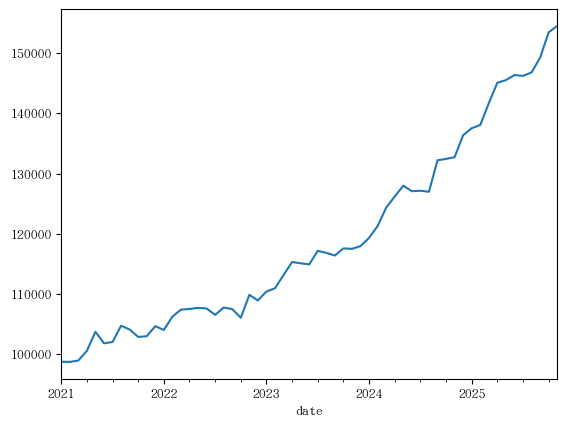

In [11]:
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple, Optional

try:
    from scipy.optimize import minimize
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False


def _annualize_vol(returns: pd.Series, periods_per_year: int = 12) -> float:
    return returns.std(ddof=1) * np.sqrt(periods_per_year)


def inverse_vol_weights(vols: np.ndarray) -> np.ndarray:
    """简单的逆波动率权重（归一化）"""
    inv = 1.0 / np.where(vols <= 0, 1e-8, vols)
    w = inv / np.sum(inv)
    return w


def _erc_weights(cov: np.ndarray, initial_guess: Optional[np.ndarray] = None) -> np.ndarray:
    """使用数值优化求解等风险贡献 (ERC) 权重。
    如果 scipy 不可用，会抛出 RuntimeError，由调用者回退到逆波动率法。
    """
    if not _HAS_SCIPY:
        raise RuntimeError("scipy is required for ERC solver but not available")

    n = cov.shape[0]
    if initial_guess is None:
        init = np.ones(n) / n
    else:
        init = initial_guess

    def portfolio_risk(w):
        return np.sqrt(w @ cov @ w)

    def risk_contribs(w):
        # marginal contribution times weight
        m = cov @ w
        total_risk = portfolio_risk(w)
        return w * m / total_risk

    def objective(w):
        rc = risk_contribs(w)
        # minimize squared deviations from equality
        target = np.mean(rc)
        return np.sum((rc - target) ** 2)

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},)
    bounds = tuple((1e-8, 1.0) for _ in range(n))
    res = minimize(objective, init, method='SLSQP', bounds=bounds, constraints=constraints)
    if not res.success:
        raise RuntimeError('ERC optimization failed: ' + str(res.message))
    w = res.x
    # enforce tiny numerical corrections
    w = np.maximum(w, 0)
    w = w / np.sum(w)
    return w


def compute_monthly_prices(prices: pd.DataFrame) -> pd.DataFrame:
    """把原始价格（可能是日频）转换为每月月末收盘价。
    要求 prices 有 DatetimeIndex 或包含 'date' 列。
    返回以月末为索引的 DataFrame。
    """
    df = prices.copy()
    if 'date' in df.columns:
        df = df.set_index(pd.to_datetime(df['date'])).drop(columns=['date'])
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError('prices must have a DatetimeIndex or a date column')
    monthly = df.resample('ME').last()
    return monthly


def backtest_blended_portfolio(
    prices: pd.DataFrame,
    alpha: float = 0.5,
    cash_col: str = '短融',
    longbond_col: str = '长债',
    gold_col: str = '黄金',
    equity_col: str = '股票',
    base_weights: Optional[Dict[str, float]] = None,
    cash_weight: float = 0.25,
    vol_lookback: int = 12,
    erc: bool = True,
    initial_capital: float = 100000.0,
    rebalance: str = 'M'
) -> Dict[str, any]:
    """
    混合永久组合 (Permanent Portfolio) 与三资产风险平价的回测函数。

    主要逻辑（按照你给的要求：永久组合各 25%，短融固定不参与 RP）：
    - 短融（cash_col）固定占 cash_weight（例如 0.25）
    - 对长债、黄金、股票计算风险平价权重（默认使用逆波动率，erc=True 时尝试 ERC）
    - 3 资产的基准永久组合权重均为 0.25（可以通过 base_weights 覆盖）
    - 先计算三资产的 blended 权重： blended3 = alpha * rp + (1-alpha) * pp3
    - 再把三资产的权重乘以 (1 - cash_weight)，最终权重加上 cash_weight 的短融

    参数：
    - prices: 包含价格的数据表，列名至少包含 shortbond/longbond/gold/equity 或者使用自定义列名
    - alpha: RP 与永久组合混合系数
    - cash_col/longbond_col/gold_col/equity_col: 对应列名
    - base_weights: 可选，字典形式覆盖永久组合权重（例如 {'长债':0.25,...}）
    - cash_weight: 短融固定权重
    - vol_lookback: 计算波动率的回看期（以月为单位）
    - erc: 如果 True, 优先尝试 ERC 求解（需要 scipy），失败则降级为逆波动率
    - initial_capital: 初始资金
    - rebalance: 资产再平衡频率，默认 'M' 按月

    返回：字典，包含净值序列、各期权重、绩效指标等
    """

    # ---------- 准备数据 ----------
    prices_monthly = compute_monthly_prices(prices)
    # 为方便计算，保留所需列
    needed = [cash_col, longbond_col, gold_col, equity_col]
    for c in needed:
        if c not in prices_monthly.columns:
            raise KeyError(f"prices missing required column: {c}")

    # 计算月度收益（用于波动率、回测收益）
    ret = prices_monthly.pct_change().dropna(how='all')

    # 永久组合 base weights（默认各 25%）
    if base_weights is None:
        base_weights = {longbond_col: 0.25, cash_col: 0.25, gold_col: 0.25, equity_col: 0.25}

    pp3 = np.array([base_weights[longbond_col], base_weights[gold_col], base_weights[equity_col]])
    # 归一化三资产的 PP 部分（理论上已经是 0.25 each）
    pp3 = pp3 / pp3.sum()

    # 结果容器
    dates = ret.index
    nav = pd.Series(index=dates, dtype=float)
    weights_history = pd.DataFrame(index=dates, columns=needed, dtype=float)

    # 初始仓位：等比例按初始净值买入（或以第一次再平衡日确定）
    nav.iloc[0] = initial_capital

    # 按月滚动计算并再平衡
    prev_weights = None
    portfolio_value = initial_capital
    # We'll keep a series of positions (number of shares) for more accurate daily/different-frequency pricing
    positions = None

    for i, date in enumerate(dates):
        # 在每个 rebalance window，计算过去 vol_lookback 月的波动
        lookback_start = max(0, i - vol_lookback)
        window_returns = ret.iloc[lookback_start:i+1]
        # If not enough data yet, fallback to using available history
        if window_returns.shape[0] < 2:
            vols = np.array([
                _annualize_vol(ret[longbond_col].iloc[:i+1]) if (i+1) > 1 else 1e-8,
                _annualize_vol(ret[gold_col].iloc[:i+1]) if (i+1) > 1 else 1e-8,
                _annualize_vol(ret[equity_col].iloc[:i+1]) if (i+1) > 1 else 1e-8,
            ])
        else:
            vols = np.array([
                _annualize_vol(window_returns[longbond_col].dropna()),
                _annualize_vol(window_returns[gold_col].dropna()),
                _annualize_vol(window_returns[equity_col].dropna()),
            ])
        # 计算 RP 权重
        try:
            if erc:
                cov = window_returns[[longbond_col, gold_col, equity_col]].cov().to_numpy()
                rp3 = _erc_weights(cov)
            else:
                rp3 = inverse_vol_weights(vols)
        except Exception:
            # 如果 ERC 失败或 scipy 不可用，回退到 inv-vol
            rp3 = inverse_vol_weights(vols)

        # blended for the 3 assets
        blended3 = alpha * rp3 + (1.0 - alpha) * pp3
        # allocate remainder after cash
        allocated3 = blended3 * (1.0 - cash_weight)
        final_weights = {
            longbond_col: allocated3[0],
            cash_col: cash_weight,
            gold_col: allocated3[1],
            equity_col: allocated3[2]
        }

        # 保存权重历史
        weights_history.loc[date] = [final_weights[c] for c in needed]

        # 计算当月组合收益：用本月的百分比收益
        # portfolio return = sum(weights * asset_returns)
        # 注意：ret.loc[date]是从上个月到本月的收益
        month_ret = 0.0
        for c in needed:
            r = ret.at[date, c] if pd.notna(ret.at[date, c]) else 0.0
            month_ret += final_weights[c] * r

        portfolio_value = portfolio_value * (1.0 + month_ret)
        nav.at[date] = portfolio_value

    # 计算绩效指标
    nav = nav.dropna()
    total_months = len(nav)
    if total_months < 2:
        raise RuntimeError('回测数据太短，至少需要 2 个观测点')

    total_return = nav.iloc[-1] / nav.iloc[0] - 1.0
    years = total_months / 12.0
    cagr = (nav.iloc[-1] / nav.iloc[0]) ** (1.0 / years) - 1.0
    # 计算月度收益序列用于波动和夏普
    monthly_rets = nav.pct_change().dropna()
    ann_vol = monthly_rets.std(ddof=1) * np.sqrt(12)
    ann_return = monthly_rets.mean() * 12
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan

    # 最大回撤
    running_max = nav.cummax()
    drawdown = nav / running_max - 1.0
    max_dd = drawdown.min()

    results = {
        'nav': nav,
        'weights': weights_history,
        'cagr': cagr,
        'annual_vol': ann_vol,
        'sharpe': sharpe,
        'total_return': total_return,
        'max_drawdown': max_dd,
        'monthly_rets': monthly_rets
    }
    return results


prices = get_data()
results = backtest_blended_portfolio(prices, alpha=0.3, cash_col='短融', longbond_col='长债', gold_col='黄金', equity_col='股票')
print('CAGR:', results['cagr'])
results['nav'].plot()
